# Modelo SIR

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

SIR sem fator de normalização
$$\ \dot{S} = - \beta I S$$
$$\ \dot{I} = \beta I S - \gamma I$$
$$\ \dot{R} = - \gamma I S$$
pois o mesmo complicaria a implementação do SINDy (acredito que a regressão teria que ser outra que não ``lstsq``, por exemplo).

obs.: variável independente ocultada para simplificar a notação

(é um sistema de EDOs...)

## Redes neurais

### Feedforward

In [17]:
np.random.seed(6661)

In [18]:
# 0 para 120
t = np.linspace(0, 120, 121)

beta = 0.2  # Taxa de infecção
gamma = 0.1  # Taxa de recuperação

nn_input = np.zeros((100 * (len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)


def sir_deriv(s_i_r, t0, beta=beta, gamma=gamma):
    s, i, r = s_i_r
    dsdt = -beta * s * i
    didt = beta * s * i - gamma * i
    drdt = gamma * i
    return [dsdt, didt, drdt]

# i = valores aleatórios entre 0.1 e 0.3
i = np.random.uniform(0.1, 0.3, 100)
# r = valores aleatórios entre 0.0 e 0.1
r = np.random.uniform(0.0, 0.1, 100)
# s = 1 - i - r
s = 1 - i - r

In [19]:
x0 = np.array([s, i, r]).T
print(x0.shape)

(100, 3)


In [20]:
x_t = np.asarray([integrate.odeint(sir_deriv, x0_j, t) for x0_j in x0])
print(x_t.shape)
x_t[1][0]

(100, 121, 3)


array([0.669, 0.247, 0.085])

In [21]:
for j in range(100):
    nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]
nn_input.shape

(12000, 3)

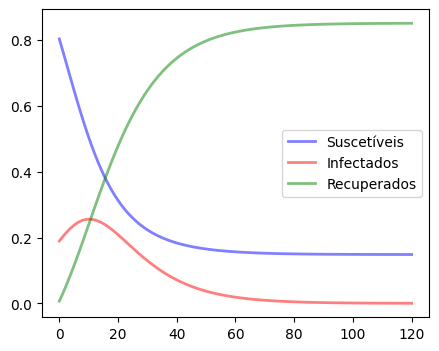

In [22]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x_t[0, :, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, x_t[0, :, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, x_t[0, :, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
plt.legend()
plt.show()

Até aqui tudo certo. Esta é mesmo a "cara" do SIR.

In [23]:
print(nn_input.shape)
print(nn_output.shape)

(12000, 3)
(12000, 3)


In [24]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='linear'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')

In [25]:
History = net.fit(nn_input, nn_output, epochs=10, verbose=1)

Epoch 1/10
375/375 [==============================] - 1s 789us/step - loss: 0.0089
Epoch 2/10
375/375 [==============================] - 0s 760us/step - loss: 2.8903e-04
Epoch 3/10
375/375 [==============================] - 0s 757us/step - loss: 1.0473e-04
Epoch 4/10
375/375 [==============================] - 0s 746us/step - loss: 1.5161e-05
Epoch 5/10
375/375 [==============================] - 0s 735us/step - loss: 1.8086e-06
Epoch 6/10
375/375 [==============================] - 0s 776us/step - loss: 1.7560e-06
Epoch 7/10
375/375 [==============================] - 0s 797us/step - loss: 1.7160e-06
Epoch 8/10
375/375 [==============================] - 0s 784us/step - loss: 1.8024e-06
Epoch 9/10
375/375 [==============================] - 0s 813us/step - loss: 1.8018e-06
Epoch 10/10
375/375 [==============================] - 0s 752us/step - loss: 1.8773e-06


In [26]:
#np.random.seed(6661)
ynn = np.zeros((1, len(t), 3))
ynn[0, 0, :] = (np.random.randint(1000, 2000), np.random.randint(100, 200), np.random.randint(0, 50))
# normalizando SIR de 0 a 1
ynn[0, 0, :] = (ynn[0, 0, :] - ynn[0, 0, :].min()) / (ynn[0, 0, :].max() - ynn[0, 0, :].min())
print(ynn[0, 0, :])
for jj, tval in enumerate(t[:-1]):
    ynn[0, jj + 1, :] = net.predict(ynn[:, jj, :], verbose = 1)

[1.    0.117 0.   ]
1/1 [==============================] - 0s 17ms/step


In [27]:
y0 = ynn[0, 0, :]
y_t = integrate.odeint(sir_deriv, y0, t)

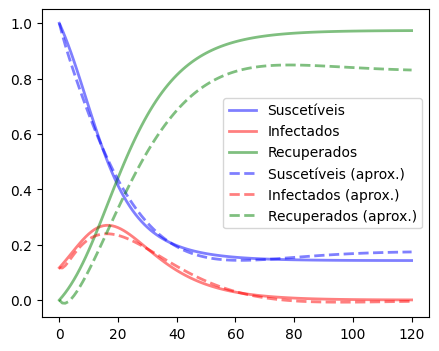

In [28]:
# plot y_t
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, y_t[:, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, y_t[:, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, y_t[:, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
# plot predição
ax.plot(t, ynn[0, :, 0], 'b--', alpha=0.5, lw=2, label='Suscetíveis (aprox.)')
ax.plot(t, ynn[0, :, 1], 'r--', alpha=0.5, lw=2, label='Infectados (aprox.)')
ax.plot(t, ynn[0, :, 2], 'g--', alpha=0.5, lw=2, label='Recuperados (aprox.)')
plt.legend()
plt.show()

Um resultado similar ao do experimento com o atrator de Lorenz: uma boa aproximação do comportamento, apesar de não muito precisa. Para a baixíssima quantidade de *epochs* e a simplicidade da rede de um modo geral, trata-se de um resultado satisfatório.

Antes deste "sucesso", foram testados: SIR não normalizado, SIR normalizado sem normalização nas entradas, SIR normalizado com normalização nas entradas. Em todos os casos, foi usada a sequência de funções de ativação: ``sigmoid``, ``relu`` e ``linear``, todas sem sucesso

### LSTM

TODO

## Métodos numéricos

### SINDy

In [29]:
dt = 0.01
T = 50
t = np.arange(dt,T+dt,dt)
n = 3

In [30]:
np.random.seed(123)
x0 = (1, 0.1, 0)
x = integrate.odeint(sir_deriv, x0, t)

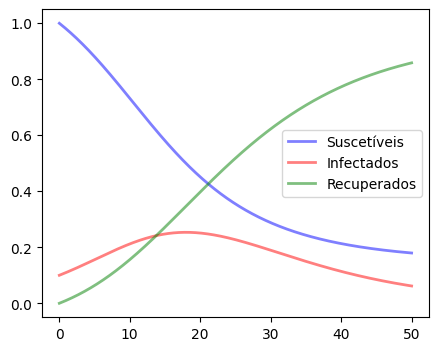

In [31]:
# plot SIR
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x[:, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, x[:, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, x[:, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
plt.legend()
plt.show()

In [32]:
# Calcula a derivada de S(t), S(t) e S(t) para t = 0.1, 0.2, ..., 50
# isto é, o lado direito das EDOs
dx = np.zeros_like(x)
for j in range(len(t)):
    dx[j,:] = sir_deriv(x[j,:],0,beta,gamma)

In [33]:
from itertools import product

# Montando as funções candidatas
# No caso, polinomiais de 0 a 3 graus
def generate_polynomial_functions():
    variables = ['x', 'y', 'z']
    powers = [1, 2, 3]
    functions = set()
    functions.add(('1',))

    for p in powers:
        combinations = product(variables, repeat=p)
        # adiciona as combinações no set
        for c in combinations:
            functions.add(tuple(sorted(c)))

    # transforma em lambda functions
    lambda_functions = []
    for f in functions:
        lambda_functions.append(lambda x, y, z, f=f: eval('*'.join(f)))

    return lambda_functions
poly = generate_polynomial_functions()

In [34]:
from datadriven.methods import SINDy

In [35]:
sindy = SINDy(x, dx, poly)

In [36]:
print(sindy.theta.shape)
sindy.theta

(5000, 20)


array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.001],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.001],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.001],
       ...,
       [0.046, 0.132, 0.053, ..., 0.154, 0.859, 0.   ],
       [0.046, 0.132, 0.053, ..., 0.154, 0.859, 0.   ],
       [0.046, 0.132, 0.053, ..., 0.154, 0.859, 0.   ]])

In [37]:
lamb = 0.025
sindy.sparsify(lamb, 10)
print(sindy.xi.shape)
sindy.xi

(20, 3)


array([[ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   , -0.091,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [-0.2  ,  0.109,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.1  ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   , -0.091,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ]])

In [38]:
sindy.xi

array([[ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   , -0.091,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [-0.2  ,  0.109,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.1  ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   , -0.091,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ]])

In [39]:
x_sindy = integrate.odeint(sindy.model, x0, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

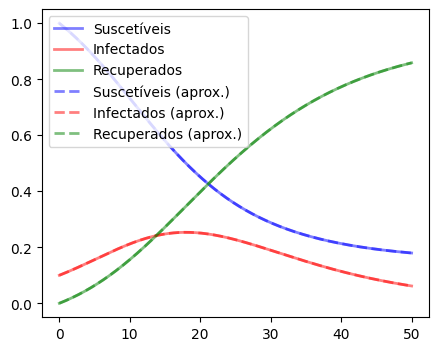

In [40]:
# plot SIR
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x[:, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, x[:, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, x[:, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
ax.plot(t, x_sindy[:, 0], 'b--', alpha=0.5, lw=2, label='Suscetíveis (aprox.)')
ax.plot(t, x_sindy[:, 1], 'r--', alpha=0.5, lw=2, label='Infectados (aprox.)')
ax.plot(t, x_sindy[:, 2], 'g--', alpha=0.5, lw=2, label='Recuperados (aprox.)')
plt.legend()
plt.show()